# Item-item based and Factorization Recommender Systems Project
### Peter Weber

### Parameters

In [1]:
# Number of items
N = 300
# Number of nearest neighbors
NN = N

### Libraries and data

In [2]:
# Use the movielens dataset with 100,000 ratings
%autosave 150
%matplotlib inline
import operator
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import cProfile
from timeit import default_timer as timer

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-100k/u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('./data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]

print("The dataset has "+ str(data.shape[0]) +" ratings")
print("The dataset has ", data.user_id.nunique()," users")
print("The dataset has ", data.movie_id.nunique(), " movies")
data.head()

Autosaving every 150 seconds
The dataset has 100000 ratings
The dataset has  943  users
The dataset has  1682  movies


,user_id,title,movie_id,rating,release_date,sex,age
0,196,Kolya (1996),242,3,24-Jan-1997,M,49
1,305,Kolya (1996),242,5,24-Jan-1997,M,23
2,6,Kolya (1996),242,4,24-Jan-1997,M,42
3,234,Kolya (1996),242,4,24-Jan-1997,M,60
4,63,Kolya (1996),242,3,24-Jan-1997,M,31


In [3]:
np.random.seed(111)

def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [4]:
### Entire data set
data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]

print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")
print("The dataset has ", data.movie_id.nunique(), " movies")

print(data.head())

Training data_set has 79619 ratings
Test data set has 20381 ratings
The dataset has  1682  movies
   user_id         title  movie_id  rating release_date sex  age  for_testing
0      196  Kolya (1996)       242       3  24-Jan-1997   M   49        False
1      305  Kolya (1996)       242       5  24-Jan-1997   M   23        False
2        6  Kolya (1996)       242       4  24-Jan-1997   M   42        False
3      234  Kolya (1996)       242       4  24-Jan-1997   M   60        False
4       63  Kolya (1996)       242       3  24-Jan-1997   M   31        False


In [5]:
### Smaller data set I will mostly work with
# take the first N movies
#items_unique = data.movie_id.unique()
#random.shuffle(items_unique) 
#dataSmall = data[data['movie_id'].isin(items_unique[:N])].copy() 

dataSmall = data[data['movie_id'].isin(data.movie_id.unique()[:N])].copy() 

dataSmall['for_testing'] = False
grouped = dataSmall.groupby('user_id', group_keys=False).apply(assign_to_set)
dataSmall_train = dataSmall[grouped.for_testing == False]
dataSmall_test = dataSmall[grouped.for_testing == True]

print(dataSmall_train.shape )
print(dataSmall_test.shape )

print('Users:', dataSmall.user_id.nunique() )
print('Films:',dataSmall.movie_id.nunique() )

print(dataSmall.head())

(34487, 8)
(9098, 8)
Users: 943
Films: 300
   user_id         title  movie_id  rating release_date sex  age  for_testing
0      196  Kolya (1996)       242       3  24-Jan-1997   M   49        False
1      305  Kolya (1996)       242       5  24-Jan-1997   M   23        False
2        6  Kolya (1996)       242       4  24-Jan-1997   M   42        False
3      234  Kolya (1996)       242       4  24-Jan-1997   M   60        False
4       63  Kolya (1996)       242       3  24-Jan-1997   M   31        False


# Item-item based Collaborative Filtering Recommender System

In the first part of the Homework I will closely follow the article:
##### [1] Item-based Collaborative Filtering Recommendation Algorithms 
by the GroupLens Research Group/Army HPC Research Center. I will refer to this article as ref.1 hereafter. Also, I am going to use the same definitions, if not stated otherwise. Let us start with the functions used to compute item-item similarities.

In [6]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean

def pearson_similarity_items(df, item1, item2, min_common_users=1):
    """
    Returns a Pearson correlation score for item1 and item2
    """    
     # GET USERS OF ITEM1
    users_item1 = df[df['movie_id'] == item1]
    # GET USERS OF ITEM2
    users_item2 = df[df['movie_id'] == item2]
    
    # FIND SHARED USERS
    users_common = pd.merge(users_item1, users_item2, on = 'user_id')
    if len(users_common)==0:
        return 0    
    if len(users_common)<min_common_users:
        return 0    
    corr=pearsonr(users_common['rating_x'],users_common['rating_y'])[0]
    if np.isnan(corr):
        return 0
    return corr

def cos_similarity_items(df, item1, item2, min_common_users=1):
    """
    Returns a cosine similarity score for item1 and item2
    """        
    # GET USERS OF ITEM1
    users_item1 = df[df['movie_id'] == item1]
    
    # GET USERS OF ITEM2
    users_item2 = df[df['movie_id'] == item2]
    
    # FIND SHARED USERS
    users_common = pd.merge(users_item1, users_item2, on = 'user_id')
    if len(users_common)==0:
        return 0    
    if(len(users_common)<min_common_users):
        return 0  

    num = users_common['rating_x'].dot(users_common['rating_y'])
    den = np.sqrt(users_common['rating_x'].dot(users_common['rating_x'])*\
                  users_common['rating_y'].dot(users_common['rating_y']))
    cos_sim = num/den
    if(np.isnan(cos_sim)):
        return 0
    return cos_sim


def adjcos_similarity_items(df_, item1, item2, min_common_users=1):
    """
    Returns an adjusted cosine similarity score for item1 and item2
    """
    df = df_.copy()
    user_means = df.groupby(['user_id'], axis=0)['rating'].transform('mean')
    df['rating'] = df['rating'] - user_means
    
    # GET USERS OF ITEM1
    users_item1 = df[df['movie_id'] == item1]
    
    # GET USERS OF ITEM2
    users_item2 = df[df['movie_id'] == item2]
    
    # FIND SHARED USERS
    u_common = pd.merge(users_item1, users_item2, on = 'user_id')
    if len(u_common)==0:
        return 0    
    if(len(u_common)<min_common_users):
        return 0 
    
    num = u_common['rating_x'].dot(u_common['rating_y'])
    den = np.sqrt(u_common['rating_x'].dot(u_common['rating_x'])*u_common['rating_y'].dot(u_common['rating_y']))
    adjcos = num/den
    if(np.isnan(adjcos)):
        return 0
    return adjcos

### Evaluation functions

In [7]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

def evaluate(estimate_f,data_train,data_test):
    """ RMSE-based predictive performance """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([estimate_f(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def evaluate_k(estimate_f,data_train,data_test,k):
    """ RMSE-based predictive performance. Takes the number k of nearest neighbors as input """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([estimate_f(u,i,k) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

### Item-item based Collaborative Filtering Class

In [672]:
class CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(i,i'). """
    
    def __init__(self,df, similarity=adjcos_similarity_items):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a person by using a weighted average
        self.df=df
        self.sim={}   
        
    def get_sim(self):
        """ Return similarity for debugging reasons """ 
        return self.sim    
        
    def train(self):
        """ Prepare data structures for estimation. Similarity matrix for items """
        all_items = set(self.df['movie_id'])
        for movie1 in all_items:
            self.sim.setdefault(movie1, {})
            a=data_train[data_train['movie_id']==movie1][['user_id']]
            data_reduced=pd.merge(data_train,a,on='user_id')
            for movie2 in all_items:
                
                if movie1==movie2: continue
                self.sim.setdefault(movie2, {})
                if(movie1 in self.sim[movie2]):continue
                sim=self.sim_method(data_reduced,movie1,movie2)
                if(sim<0):
                    self.sim[movie1][movie2]=0
                    self.sim[movie2][movie1]=0
                else:
                    self.sim[movie1][movie2]=sim
                    self.sim[movie2][movie1]=sim
        
    def get_most_similar_items(self, movie_id, k):
        sorted_sim_of_item = sorted(self.sim[movie_id].items(), key=operator.itemgetter(1), reverse = True)
        most_similar_items = [sorted_sim_of_item[i][0] for i in range(k-1)]
        return(most_similar_items)
            
    def predict(self, user_id, movie_id, k):
        
        # Extract k most similar items
        most_similar_items = set(self.get_most_similar_items(movie_id, k))
        
        totals={}
        user_movies=self.df[self.df['user_id'] == user_id]
        rating_num=0.0
        rating_den=0.0
        all_items=set(user_movies['movie_id'])
        
        # Intersection of k most similar items with items that have been commonly rated
        intersect_items = most_similar_items & all_items
        
        for other in intersect_items:
            if movie_id==other: continue 
            rating_num += self.sim[movie_id][other] * float(user_movies[user_movies['movie_id']==other]['rating'])
            rating_den += self.sim[movie_id][other]

        if rating_den==0: 
            if self.df.rating[self.df['user_id']==user_id].mean()>0:
                # return the mean user rating if there is no similar for the computation
                return self.df.rating[self.df['user_id']==user_id].mean()
            else:
                # else return mean movie rating 
                return self.df.rating[self.df['movie_id']==movie_id].mean()
        
        return rating_num/rating_den


### Evaluate RMSE with cosine similarity on small dataset

In [449]:
reco_item_cos = CollaborativeFiltering(dataSmall_train, similarity=cos_similarity_items)
reco_item_cos.train()

In [450]:
rmse_cos = evaluate_k(reco_item_cos.predict,dataSmall_train,dataSmall_test, k = N)
print('RMSE for Collaborative Recommender with cosine similarity: %s' % rmse_cos)

RMSE for Collaborative Recommender with cosine similarity: 1.08829982725


### Evaluate RMSE with adjusted cosine similarity on small dataset

In [673]:
reco_item_adjcos = CollaborativeFiltering(dataSmall_train, similarity=adjcos_similarity_items)
reco_item_adjcos.train()

In [674]:
rmse_adjcos = evaluate_k(reco_item_adjcos.predict,dataSmall_train,dataSmall_test, k = N)
print('RMSE for Collaborative Recommender with adjusted cosine similarity: %s' % rmse_adjcos)

RMSE for Collaborative Recommender with adjusted cosine similarity: 0.968010537363


### Evaluate RMSE with correlation similarity on small dataset

In [453]:
reco_item_corr = CollaborativeFiltering(dataSmall_train, similarity=pearson_similarity_items)
reco_item_corr.train()

/Users/peterweber/Programs/anaconda2/envs/py3p6/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [454]:
rmse_corr = evaluate_k(reco_item_corr.predict,dataSmall_train,dataSmall_test, k = N)
print('RMSE for Collaborative Recommender with correlation similarity: %s' % rmse_corr)

RMSE for Collaborative Recommender with correlation similarity: 1.02470049293


# Relative performance of different similarity measures
I will reproduce Fig.4 of Ref.1, but instead of plotting Mean Absolute Error, I will be working with RMSE. 

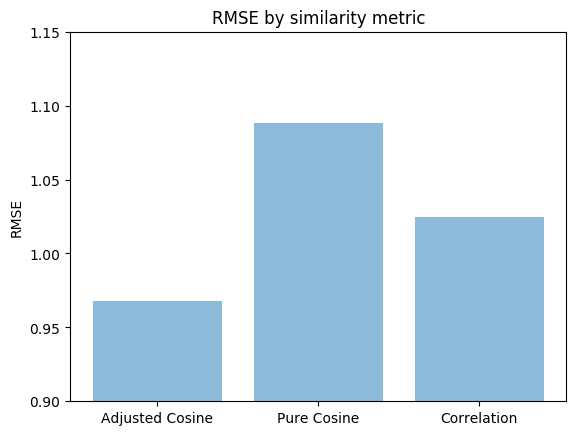

In [469]:
similarity_measures = ('Adjusted Cosine', 'Pure Cosine', 'Correlation')
y_pos = np.arange(len(similarity_measures))

RMSEs = [rmse_adjcos, rmse_cos, rmse_corr]

plt.bar(y_pos, RMSEs, align='center', alpha=0.5)
plt.xticks(y_pos, similarity_measures)
plt.ylabel('RMSE')
plt.ylim(0.9, 1.15)
plt.title('RMSE by similarity metric')

We observe similar qualitative behaviour as in ref. 1.

# Sensitivity of the neighborhood size
I will reproduce Figure 5 of Ref.1.

### Evaluation of RMSE as function of number of nearest neighbors

In [456]:
reco_adjcos_NN = []
nearest_neighbors = []
for i in range(int(N/10), N+1, int(N/10)):
    nearest_neighbors.append(i)
    reco_adjcos_NN.append(evaluate_k(reco_item_adjcos.predict,dataSmall_train,dataSmall_test, k = i))

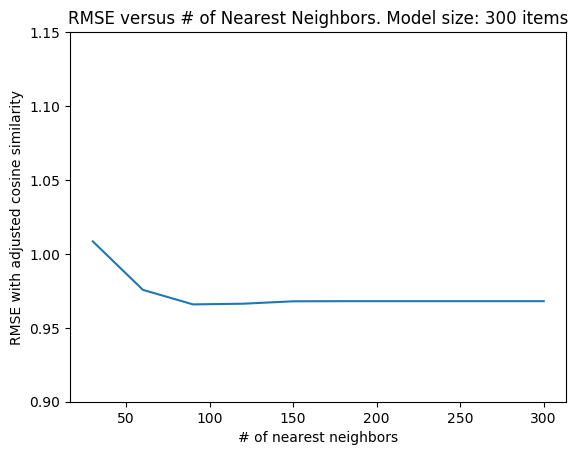

In [457]:
plt.plot(nearest_neighbors, reco_adjcos_NN)
plt.ylim(0.9, 1.15)
plt.xlabel('# of nearest neighbors')
plt.ylabel('RMSE with adjusted cosine similarity')
plt.title('RMSE versus # of Nearest Neighbors. Model size: {} items'.format(N))

# Sensitivity of the model size
Here I will reproduce figure 7, but taking only one train/test ratio (0.8/0.2)

In [458]:
model_size = []
rmses = []
times_train = []
times_predict = []

for i in range(int(N/10), N+1, int(N/10)):
    
    data_model_size = data[data['movie_id'].isin(data.movie_id.unique()[:i])].copy() 
    data_model_size['for_testing'] = False
    grouped = data_model_size.groupby('user_id', group_keys=False).apply(assign_to_set).copy()
    data_model_size_train = data_model_size[grouped.for_testing == False]
    data_model_size_test = data_model_size[grouped.for_testing == True]
    
    start_training = timer()
    reco_model_size = CollaborativeFiltering(data_model_size_train, similarity=adjcos_similarity_items)
    reco_model_size.train()
    end_training = timer()
    
    start_prediction = timer()
    rmse = evaluate_k(reco_item_adjcos.predict,data_model_size_train,data_model_size_test, k = i)
    #print('RMSE for CF recommender with adjcos similarity: {} and model size: {}'.format(rmse, i))
    end_prediction = timer()
    
    times_train.append(end_training - start_training)
    times_predict.append(end_prediction - start_prediction)
    model_size.append(i)
    rmses.append(rmse)

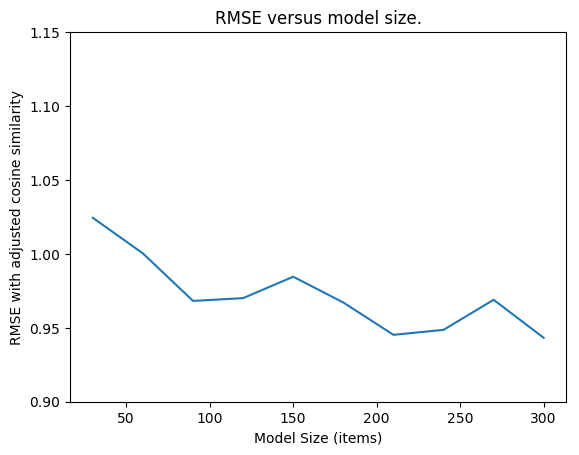

In [459]:
plt.plot(model_size, rmses)
plt.ylim(0.9, 1.15)
plt.xlabel('Model Size (items)')
plt.ylabel('RMSE with adjusted cosine similarity')
plt.title('RMSE versus model size.')

In this plot, I take the number of neighbors equal to the model size for every point. Here, the plot doesn't show the same qualitative behaviour as in ref.1. Also we observe more noise. I assume that this depends on seed of the random number generator that selects the items.

# Training time and prediction time vs. model size

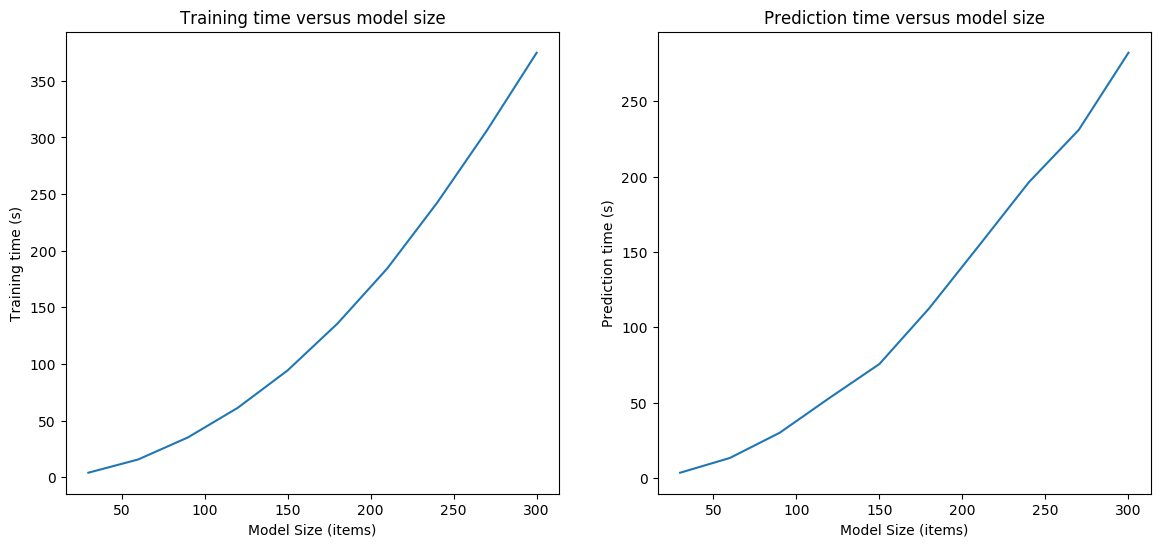

In [460]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(model_size, times_train)
ax1.set_xlabel('Model Size (items)')
ax1.set_ylabel('Training time (s)')
ax1.set_title('Training time versus model size')

ax2.plot(model_size, times_predict)
ax2.set_xlabel('Model Size (items)')
ax2.set_ylabel('Prediction time (s)')
ax2.set_title('Prediction time versus model size')

# Factorization based recommender system

### Latent Factor Factorization Model (the one provided in class)
The LatentFactorCF class below is the factorization model that was provided in class. I will first evaluate this model, in order to have a reference for improvements.

The model is based on modeling the observed ratings using latent factors both for the items $q_i \in \mathbb{R}^f$ and the users $p_u \in \mathbb{R}^f$, where $f$ is the number of latent components. The estimator for the ratings is then given as

$$
\hat{r}_{ui} = q_i^T \cdot p_u.
$$

In general, the latent factor vectors can be obtained from dimensionality reduction techniques, such as Singular Value Decompositon or Principal Components Analysis. These techniques suffer from the fact, that one has to deal with missing values, which can be inaccurate. As mentioned before, another way is to model the observed ratings only. In this scenario, the ratings are found by optimizing a regularized least squares equation for $p_u$ and $q_i$

$$
min_{q*, p*} \sum_{(u,i)\in K} (r_{ui} - q_i^T \cdot p_u)^2 + \lambda (||p_u||^2 + ||q_i||^2).
$$

Here, $K$ is the set of indices for the observed ratings $r_{ui}$.

In [461]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

class LatentFactorCF:
    """ This is the latent factor CF class that was provided. """
    
    def __init__(self,df_train,df_test,
                 num_components=50,
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0):
        """ Constructor """
        self.df = df_train
        self.test = df_test
        self.num_components = num_components
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        
        self.urm = pd.pivot_table(self.df[['user_id','movie_id','rating']],\
                                  columns='movie_id',index='user_id',values='rating',fill_value=0)

        self.n_users, self.n_items = self.urm.shape
        self.ratings = np.float32(self.urm.values)
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index))
        self.users_index2id = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns))   
        self.movies_index2id = dict(zip(self.urm.columns,movie_index))

        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
    
    def __sgd__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u] # user_id is the row_index in urm
            item_id = self.movies[i] # item_id is the col_index in urm
            
            prediction = self.estimate(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * (error * self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * (error * self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i,:])
                
                
    def learn(self,n_iter = 10, learning_rate=0.001):
        """ Train the model. """
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,# num_components: size of latent vectors
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))

        self.learning_rate = learning_rate
        
        ctr =1
        while ctr <= n_iter:
            if ctr % 1 == 0:
                print('Iteration: {}'.format(ctr))
            self.training_indices = np.arange(self.n_samples)
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sgd__()
            learning_rate = 0.99*learning_rate
            ctr += 1
            if ctr % 1 == 0:
                print('\tTrain RMSE: %s' % evaluate(self.estimate,self.df,self.df))
                print('\tTest RMSE: %s' % evaluate(self.estimate,self.test,self.df))
    
    def estimate(self, user_id, movie_id):
        """ Single user and item prediction."""
        u = self.users_index2id[user_id]
        i = self.movies_index2id[movie_id]
        prediction =  self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        return prediction
    

### Results from class on the full data set

In [462]:
reco_svd = LatentFactorCF(data_train,data_test,item_fact_reg=0.01,user_fact_reg=0.01)
reco_svd.learn(n_iter = 50, learning_rate = 0.02)

Iteration: 1
	Train RMSE: 1.30600852879
	Test RMSE: 1.26545834952
Iteration: 2
	Train RMSE: 1.05746771961
	Test RMSE: 1.19673249969
Iteration: 3
	Train RMSE: 1.01997572121
	Test RMSE: 1.18629410742
Iteration: 4
	Train RMSE: 0.995414745176
	Test RMSE: 1.1781208732
Iteration: 5
	Train RMSE: 0.970123307108
	Test RMSE: 1.17042773506
Iteration: 6
	Train RMSE: 0.945168686392
	Test RMSE: 1.1613797892
Iteration: 7
	Train RMSE: 0.915537372435
	Test RMSE: 1.15247596565
Iteration: 8
	Train RMSE: 0.884488186225
	Test RMSE: 1.14342629607
Iteration: 9
	Train RMSE: 0.854860786049
	Test RMSE: 1.13664895602
Iteration: 10
	Train RMSE: 0.825778915933
	Test RMSE: 1.13023543272
Iteration: 11
	Train RMSE: 0.800456516181
	Test RMSE: 1.12503542205
Iteration: 12
	Train RMSE: 0.778563142172
	Test RMSE: 1.12108968975
Iteration: 13
	Train RMSE: 0.759497095214
	Test RMSE: 1.11737978589
Iteration: 14
	Train RMSE: 0.742624277886
	Test RMSE: 1.11444712347
Iteration: 15
	Train RMSE: 0.729490263796
	Test RMSE: 1.112058

### Results from class on the small data set

In [463]:
reco_svd_small = LatentFactorCF(dataSmall_train,dataSmall_test,item_fact_reg=0.01,user_fact_reg=0.01)
reco_svd_small.learn(n_iter = 50, learning_rate = 0.02)

Iteration: 1
	Train RMSE: 1.34944508251
	Test RMSE: 1.26945306187
Iteration: 2
	Train RMSE: 1.02611879892
	Test RMSE: 1.1885091486
Iteration: 3
	Train RMSE: 0.998742323547
	Test RMSE: 1.18047599195
Iteration: 4
	Train RMSE: 0.979031257689
	Test RMSE: 1.17600425104
Iteration: 5
	Train RMSE: 0.952944819609
	Test RMSE: 1.17204506618
Iteration: 6
	Train RMSE: 0.922812656711
	Test RMSE: 1.16539613845
Iteration: 7
	Train RMSE: 0.89156727469
	Test RMSE: 1.15859730051
Iteration: 8
	Train RMSE: 0.859752545149
	Test RMSE: 1.15267508943
Iteration: 9
	Train RMSE: 0.830234893176
	Test RMSE: 1.14680507119
Iteration: 10
	Train RMSE: 0.79942805426
	Test RMSE: 1.14215781555
Iteration: 11
	Train RMSE: 0.770340250083
	Test RMSE: 1.13604231674
Iteration: 12
	Train RMSE: 0.747841845869
	Test RMSE: 1.13126225571
Iteration: 13
	Train RMSE: 0.727378664777
	Test RMSE: 1.12773441981
Iteration: 14
	Train RMSE: 0.70941688035
	Test RMSE: 1.12444900228
Iteration: 15
	Train RMSE: 0.694946706859
	Test RMSE: 1.1219381

## Latent Factor Factorization Model (my implementation)

#### SVD++
After looking at a few of the articles that were referred to in class I first decided to implement a Latent Factor based SVD++. The estimator for the ratings for an SVD++ is given by the following equation

$$
\hat{r}_{ui} = b_{ui} + q_i^T \left(p_u + |N(u)|^{-0.5} \sum_{j \in N(u)} y_i \right)
$$

where $b_{ui} = \mu + b_u + b_i$ is the bias term, $\mu$ the overall average rating, $b_u$ the average rating of user u, $b_i$ the average rating of item i, $N(u)$ the set of items user u has provided implicit feedback and $y_i$ a factor vector term related to the implicit feedback of the user. The latent factor vector $y_i$ has the same dimensions as the latent factor vectors $q_i$ and $p_u$.

When implementing SVD++, I realized that the computation and the updates of the SGD are computationally very demanding due to the implicit feedback. Additionally, on the MovieLens data set, implicit feedback is not expected to increase the performance significantly, since there is no additional information available about the users. Therefore, I abandoned the idea of using implicit feedback for my further computations. However, an implementation of SVD++ that I haven't tested thoroughly can be found in the Appendix.

Then I decided to implement an integrated model: A combination of Neighborhood based prediction with a Latent Factor model as it is proposed in
### [2] Factorization Meets the Neighborhood: a Multifaceted Colaborative Filtering Model
by Yehuda Koren from AT&T Labs. Hereafter, I will refer to this article as ref. 2.

#### Integrated model (excluding implicit feedback)

The author proposes to model ratings (in the case of excluding implicit feedback) in the following way

\begin{equation}
\hat{r}_{ui} = \mu + b_{u} + b_{i} + q_i^T \cdot p_u + |R^k(i;u)|^{-1/2} \sum_{j \in R^k(i;u)} (r_{uj} - b_{uj})w_{ij}.
\label{eq:r_ui}
\end{equation}

Here, $R^k(i;u)$ is the set of items most similar to $i$ rated by user $u$. Further, one considers only the k nearest neighbors of $i$. The weights $w_{ij}$ are some form of similarity measure between item $i$ and item $j$. In the interpretation of the author the weights represent offsets from baseline estimates and $r_{uj} - b_{uj}$ are the coefficients multiplying those offsets. It is very important to mention, that the $b_u$ and $b_i$ are updated via SGD, but the $b_{uj}$ are constants as determined from the inherent and constant average rating $b_u$ of user u and average rating $b_i$ of item i (and overall average rating $\mu$), respectively.

To find the best predictions for the ratings one again has to minimize a regularized least squares equation of the form

$$
min_{q*, p*, w*, b*} \sum_{(u,i)\in K} \left( (r_{ui} - \hat{r}_{ui})^2 + \lambda_1 (||b_u||^2 + ||b_i||^2) + \lambda_2(||p_u||^2 + ||q_i||^2) + \lambda_3(\sum_{j \in R^k(i;u)} ||w_{ij}||^2)) \right)
$$

where one has to plug in $\hat{r}_{ui}$ from the paragraph before. The gradient descent update rules can be looked up in ref. 2 on page 8. I will implement these update rules, but excluding implicit feedback (i.e. ignoring all terms containing $N(u)$ and $N^k(i;u)$). Here again I emphasize that the $b_u$ and $b_i$ are updated by SGD, but the $b_{uj}$ are constant. 

In order to implement the model, I follow the following steps. I take the LatentFactorCF class, and I add the bias terms. Then, I combine the LatentFactorCF with the CollaborativeFiltering model from the first part of this homework by adding the similarity computation. The implementation of parameter initializations and updates precedes the determination of the set $R^k(i;u)$ from the similarity matrix.

In [678]:
class LatentFactorSvdIntegrated:
    """
    This is a combination of the latent factor class and the nearest neighbor CF class
    following the definitions of the previous paragraph.
    """
    
    def __init__(self,train,test,
                 similarity=adjcos_similarity_items,
                 similarity_matrix=None,
                 kNN = 40,
                 num_components = 50,
                 fact_reg=0.0, 
                 bias_reg = 0.0,
                 weights_reg = 0.0):
        
        """ Constructor """
        self.kNN = kNN
        self.df = train
        self.test = test
        self.sim_method=similarity
        self.num_components = num_components
        self.fact_reg = fact_reg
        self.bias_reg = bias_reg
        self.weights_reg = weights_reg
        self.sim_provided = similarity_matrix
        
        # Nearest neighbor similarity construction
        self.sim_method=similarity
        self.sim={} 
        
        # Fill here with NAs so that mean can be calculated without taking NAs into account
        self.urm_nan = pd.pivot_table(self.df[['user_id','movie_id','rating']],\
                                      columns='movie_id',index='user_id',values='rating',fill_value=np.nan)
        # This is the overall mean µ
        self.mu = np.nanmean(self.urm_nan)
        
        # Fill in zero's again
        self.urm = self.urm_nan.fillna(value = 0, inplace = False)
        
        self.n_users, self.n_items = self.urm.shape
        self.ratings = np.float32(self.urm.values)
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index))
        self.users_index2id = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns))   
        self.movies_index2id = dict(zip(self.urm.columns,movie_index))

        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)               
    
    def get_most_similar_items(self, movie_id):
        """ This function returns the self.kNN most similar items in sorted descending order """
        sorted_sim_of_item = sorted(self.sim[movie_id].items(), key=operator.itemgetter(1), reverse = True)
        most_similar_items = [sorted_sim_of_item[i][0] for i in range(self.kNN-1)]
        return(most_similar_items)
    
    def get_k_most_similar_items(self, user_id, movie_id):
        """ This function computes the set R^k(i;u) as described in the theoretical part """
        
        # Extract k most similar items
        most_similar_items = set(self.get_most_similar_items(movie_id))
        
        # Extract items user has rated
        user_movies=self.df[self.df['user_id'] == user_id]
        all_items=set(user_movies['movie_id'])
        
        # Intersection of k most similar items with items that have been commonly rated
        intersect_items = most_similar_items & all_items
        return intersect_items
    
    def convert_k_most_similar_items_to_dict(self):
        """ This function converts the output of get_k_most_similar_items
            into a double dict for performane reasons: creates self.k_most_sim """
        self.k_most_sim = {}
        for user_id in self.users_index2id.keys():
            self.k_most_sim.setdefault(user_id, {})
            for movie_id in self.movies_index2id.keys():
                self.k_most_sim[user_id][movie_id] = self.get_k_most_similar_items(user_id, movie_id)
    
    def train_similarity(self):            
        """ Train Similarity matrix for items as in item-item CF"""
        
        ## This trains self.sim, do it if there is no matrix provided as input
        ## Otherwise use provided input 
        if self.sim_provided == None:
            start = timer()
            print("Compute similarity matrix!")
            all_items = set(self.df['movie_id'])
            for movie1 in all_items:
                self.sim.setdefault(movie1, {})
                a=data_train[data_train['movie_id']==movie1][['user_id']]
                data_reduced=pd.merge(data_train,a,on='user_id')
                for movie2 in all_items:

                    if movie1==movie2: continue
                    self.sim.setdefault(movie2, {})
                    if(movie1 in self.sim[movie2]):continue
                    sim=self.sim_method(data_reduced,movie1,movie2)
                    if(sim<0):
                        self.sim[movie1][movie2]=0
                        self.sim[movie2][movie1]=0
                    else:
                        self.sim[movie1][movie2]=sim
                        self.sim[movie2][movie1]=sim
            print("Time for computation of similarity matrix in s:", timer() - start)
        else:
            print("Use provided similarity matrix!")
            self.sim = self.sim_provided.copy()

        # self.k_most_sim as double dictionary
        # This is the set R^k(i;u) for all i and u
        start = timer()
        self.convert_k_most_similar_items_to_dict()
        print("Time for conversion to dict in s:", timer() - start)
    
    def __sgd__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx] # u is a 0...n python row idx of users
            i = self.sample_col[idx] # i is a 0...m python col idx of items
            user_id = self.users[u] # user_id is the row_index in urm
            item_id = self.movies[i] # item_id is the col_index in urm
            
            prediction = self.estimate(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            # Update latent factors
            self.user_vecs[u, :] += self.learning_rate_fact *\
                                    (error * self.item_vecs[i, :] - self.fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate_fact *\
                                    (error * self.user_vecs[u, :] - self.fact_reg * self.item_vecs[i,:])
            
            # Update user bias and item bias
            self.bias_user[u,] += self.learning_rate_bias * (error - self.bias_reg * self.bias_user[u,])
            self.bias_item[i,] += self.learning_rate_bias * (error - self.bias_reg * self.bias_item[i,]) 
            
            # update similarity weights
            aux = self.k_most_sim[user_id][item_id]
            #print("size of aux:", len(aux))
            for j_item_id in aux:
                j = self.movies_index2id[j_item_id]
                bias_const = self.bias_user_const[u,] + self.bias_item_const[j] + self.mu
                self.weights[item_id][j_item_id] += self.learning_rate_weights*\
                    (1.0/np.sqrt(len(aux))*error*(self.ratings[u,j] - bias_const) - self.weights_reg * self.weights[item_id][j_item_id])
    
    def learn(self,n_iter = 10, learning_rate_fact=0.001, learning_rate_bias=0.001, learning_rate_weights=0.001):
        """ Train Latent Factor CF """        
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        
        # initialize latent vectors, num_components: size of latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        
        # initialize user bias and item bias
        self.bias_user = np.nanmean(self.urm_nan, axis = 1) - self.mu
        self.bias_item = np.nanmean(self.urm_nan, axis = 0) - self.mu     
        
        # constant biases, these are not updated by SGD
        self.bias_user_const = self.bias_user.copy()
        self.bias_item_const = self.bias_item.copy()
        
        # initialize similarity weights
        self.weights = self.sim.copy()
        
        # learning rate
        self.learning_rate_fact = learning_rate_fact
        self.learning_rate_bias = learning_rate_bias
        self.learning_rate_weights = learning_rate_weights
        
        ctr =1
        while ctr <= n_iter:
            if ctr % 1 == 0:
                print('Iteration: {}'.format(ctr))
            self.training_indices = np.arange(self.n_samples) # samples are the users
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sgd__()
            self.learning_rate_fact = 0.98*self.learning_rate_fact
            self.learning_rate_bias = 0.98*self.learning_rate_bias
            self.learning_rate_weights = 0.98*self.learning_rate_weights
            ctr += 1   
            if ctr % 1 == 0:
                train_rmse = evaluate(self.estimate,self.df,self.df)
                test_rmse = evaluate(self.estimate,self.test,self.df)
                self.train_mse.append(train_rmse)
                self.test_mse.append(test_rmse)
                print('\tTrain RMSE: %s' % train_rmse)
                print('\tTest RMSE: %s' % test_rmse)
    
    def estimate(self, user_id, movie_id):
        """ Prediction method for \hat{r}_{ui} including all components explained in theoretical part """

        u = self.users_index2id[user_id]
        i = self.movies_index2id[movie_id]
        
        # Add to prediction overall mean and bias terms
        prediction = self.mu + self.bias_user[u,] + self.bias_item[i,] + self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        
        # Add similarity weights contribution to prediction
        aux = self.k_most_sim[user_id][movie_id]
        #print("size of aux:", len(aux))
        for j_item_id in aux:
            j = self.movies_index2id[j_item_id]
            bias_const = self.bias_user_const[u,] + self.bias_item_const[j] + self.mu
            weights_contr = 1.0/np.sqrt(len(aux)) * (self.ratings[u,j] - bias_const) * self.weights[movie_id][j_item_id]
            #print(weights_contr)
            prediction += weights_contr
                
        return prediction
    
    # Getters for debugging
    def get_urm(self):
        return self.urm
    
    def get_items(self):
        return self.movies, self.movies_index2id
    
    def get_users(self):
        return self.users, self.users_index2id
    
    def get_ratings(self):
        return self.ratings
    
    def get_samples(self):
        return self.sample_row, self.sample_col
    
    def get_user_vecs(self):
        return self.user_vecs
    
    def get_bias(self):
        self.bias_user = np.nanmean(self.urm_nan, axis = 1) - self.mu
        self.bias_item = np.nanmean(self.urm_nan, axis = 0) - self.mu
        return self.bias_user, self.bias_item
    
    def get_user_imp_items(self):
        return self.user_imp_items
    
    def get_sim(self):
        return self.sim   
    
    def most_sim_items_matrix(self):
        return self.k_most_sim
    
    def get_rmse(self):
        return train_mse, test_mse
    
    def get_weights(self):
        return self.weights

In [679]:
sim_matrix = reco_item_adjcos.get_sim().copy() # This matrix can be used in the next class to avoid computing self.sim
#sim_matrix

In [680]:
reco_svd_int = LatentFactorSvdIntegrated(dataSmall_train, dataSmall_test,
                                         #similarity_matrix = sim_matrix,
                                         kNN = 100,
                                         fact_reg=0.0, 
                                         bias_reg = 0.0,
                                         weights_reg = 0.0)
reco_svd_int.train_similarity()

Compute similarity matrix!
Time for computation of similarity matrix in s: 535.2341220410308
Time for conversion to dict in s: 316.3297392380191


### Training the algorithm with 300 movies

In [681]:
reco_svd_int.learn(n_iter = 100, learning_rate_fact=0.03, learning_rate_bias = 0.003, learning_rate_weights=0.03) 
#reco_svd_int.learn(n_iter = 100, learning_rate_fact=0.0, learning_rate_bias = 0.00, learning_rate_weights=0.01) 

Iteration: 1
	Train RMSE: 0.954342950983
	Test RMSE: 1.17107173801
Iteration: 2
	Train RMSE: 0.942617357548
	Test RMSE: 1.16858381339
Iteration: 3
	Train RMSE: 0.93252854678
	Test RMSE: 1.16644077982
Iteration: 4
	Train RMSE: 0.918485004231
	Test RMSE: 1.16347814067
Iteration: 5
	Train RMSE: 0.89441742649
	Test RMSE: 1.15836114225
Iteration: 6
	Train RMSE: 0.859827243639
	Test RMSE: 1.15131167726
Iteration: 7
	Train RMSE: 0.820594936763
	Test RMSE: 1.14367678937
Iteration: 8
	Train RMSE: 0.781347090787
	Test RMSE: 1.13643863554
Iteration: 9
	Train RMSE: 0.745974763195
	Test RMSE: 1.13015777425
Iteration: 10
	Train RMSE: 0.716133799786
	Test RMSE: 1.1251027268
Iteration: 11
	Train RMSE: 0.69204196718
	Test RMSE: 1.12112640519
Iteration: 12
	Train RMSE: 0.672904720327
	Test RMSE: 1.11802908485
Iteration: 13
	Train RMSE: 0.657774264164
	Test RMSE: 1.11559217912
Iteration: 14
	Train RMSE: 0.645758860674
	Test RMSE: 1.11369650502
Iteration: 15
	Train RMSE: 0.636212993181
	Test RMSE: 1.11217

As can be seen the RMSE for this version of the implemented model is about 1.1. For some reason, this is significantly worse than the result of the item-itme based CF model. I have tried several paramaters, and different combinations of learning rates, but the parameter space is too large for a systematic analysis (taking into account the time needed to initialize the model). I further checked the impact of the different contributions to the prediction, the latent factors, the bias terms, and the terms related to similarity weights. The latent factors are by far the most important contribution to the predictions, whereas the bias terms lead to more accurate predictions for the first few iterations. However, the weight terms seem to have no impact on the prediction quality, i.e. the model provided in class essentially gives the same RMSE as the more advanced integrated model. At the current state, I can not identify the root cause for this. I assume it is related to something that I am missing in the implementation of the algorithm of ref. 2, or, which I believe is not very likely, due to ignoring the implicit feedback terms. If I had more time and more computing power available I would investigate towards this direction.

# ----------------------------------------------------------------------------------------------------------------------------------- Appendix ----------------------------------------------------------------------------------------------------------------------------------------


### SVD++

In [ ]:
class LatentFactorSvdPp:
    """
    This is the latent factor CF class that was provided, but I added Bias and implicit feedback
    """
    
    def __init__(self,train,test, 
                 num_components=10,
                 fact_reg=0.0, 
                 bias_reg = 0.0,
                 implicit_feedback = False):
        """ Constructor """
        self.df = train
        self.test = test
        self.num_components = num_components
        self.fact_reg = fact_reg
        self.bias_reg = bias_reg
        self.implicit_feedback = implicit_feedback
        
        # Fill here with NAs so that mean can be calculated without taking NAs into account
        self.urm_nan = pd.pivot_table(self.df[['user_id','movie_id','rating']],\
                                      columns='movie_id',index='user_id',values='rating',fill_value=np.nan)
        # This is the overall mean µ
        self.mu = np.nanmean(self.urm_nan)
        
        # Fill in zero's again
        self.urm = self.urm_nan.fillna(value = 0, inplace = False)
        
        self.n_users, self.n_items = self.urm.shape
        self.ratings = np.float32(self.urm.values)
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index))
        self.users_index2id = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns))   
        self.movies_index2id = dict(zip(self.urm.columns,movie_index))

        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        if self.implicit_feedback:
            # Define N(u): items that user provided implicit preference
            self.user_imp_items = {}
            for u in self.sample_row:
                self.user_imp_items[u] = self.sample_col[self.sample_row == u].tolist()                
    
    def __sgd__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx] # u is a 0...n python row idx in ratings
            i = self.sample_col[idx] # i is a 0...m python col idx in ratings
            user_id = self.users[u] # user_id is the row_index in urm
            item_id = self.movies[i] # item_id is the col_index in urm
            
            prediction = self.estimate(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            # Update latent factors
            self.user_vecs[u, :] += self.learning_rate_fact *\
                                    (error * self.item_vecs[i, :] - self.fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate_fact * (error * self.user_vecs[u, :] - self.fact_reg * self.item_vecs[i,:])
            
            # If implicit feedback should be considered
            if self.implicit_feedback:
                # Update implicit vectors
                for j in self.user_imp_items[u]:
                    self.y_vecs[j, :] += self.learning_rate_fact *\
                                         (error * self.item_vecs[i, :] - len(self.user_imp_items[u]) ** (-0.5) -\
                                         self.fact_reg * self.y_vecs[j, :])
                
                # Update item vector with implicit feedback component
                for j in self.user_imp_items[u]:
                    self.item_vecs[i, :] += self.learning_rate_fact * error * len(self.user_imp_items[u])**(-0.5) *\
                                            self.y_vecs[j, :]
            
            # Update user bias and item bias
            self.bias_user[u,] += self.learning_rate_bias * (error - self.bias_reg * self.bias_user[u,])
            self.bias_item[i,] += self.learning_rate_bias * (error - self.bias_reg * self.bias_item[i,]) 
                
    def learn(self,n_iter = 10, learning_rate_fact=0.001, learning_rate_bias=0.001):    
        """ Train the model. """
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        
        # initialize latent vectors, num_components: size of latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        if self.implicit_feedback:
            self.y_vecs = np.random.normal(scale=1./self.num_components,
                                           size=(self.n_items, self.num_components)) 
        
        # initialize user bias and item bias
        self.bias_user = np.nanmean(self.urm_nan, axis = 1) - self.mu
        self.bias_item = np.nanmean(self.urm_nan, axis = 0) - self.mu
        
        # learning rate
        self.learning_rate_fact = learning_rate_fact
        self.learning_rate_bias = learning_rate_bias
        
        ctr =1
        while ctr <= n_iter:
            if ctr % 1 == 0:
                print('Iteration: {}'.format(ctr))
            self.training_indices = np.arange(self.n_samples) # samples are the users
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sgd__()
            ctr += 1
                
            print('\tTrain RMSE: %s' % evaluate(self.estimate,self.df,self.df))
            print('\tTest RMSE: %s' % evaluate(self.estimate,self.test,self.df))
    
    def estimate(self, user_id, movie_id):
        """ Single user and item prediction."""

        u = self.users_index2id[user_id]
        i = self.movies_index2id[movie_id]
        
        # Add to prediction overall mean and bias terms
        prediction = self.mu + self.bias_user[u,] + self.bias_item[i,] +\
                            self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        
        if self.implicit_feedback:
            for j in self.user_imp_items[u]:
                prediction += len(self.user_imp_items[u])**(-0.5) + self.item_vecs[i, :].dot(self.y_vecs[j, :].T)
                
        return prediction